# 1. 데이터 셋 다운로드 및 압축해제
https://www.kaggle.com/datasets/dansbecker/5-celebrity-faces-dataset?resource=download

In [2]:
# 얼굴인식(얼굴정보)세로*가로*3 넘파이 -> 1*512(임베딩데이터로 변환) -> X, y를 머신러닝(SVM)

In [1]:
!unzip data/5celebrity.zip -d data/5celebrity/

Archive:  data/5celebrity.zip
   creating: data/5celebrity/train/
   creating: data/5celebrity/train/ben_afflek/
  inflating: data/5celebrity/train/ben_afflek/httpcsvkmeuaeccjpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpssmediacacheakpinimgcomxdbbdbbbececacdecdcdfjpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpssmediacacheakpinimgcomxeeedcacddeccccacfjpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAffleckbyGageSkidmorejpg.jpg  


# 2. 얼굴 Detect

In [3]:
# ! pip install mtcnn

     ---------------------------------------- 1.9/1.9 MB 13.4 MB/s eta 0:00:00
     ---------------------------------------- 99.8/99.8 kB 5.6 MB/s eta 0:00:00
     ------------------------------------- 301.8/301.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: lz4
    Found existing installation: lz4 3.1.3
    Uninstalling lz4-3.1.3:
      Successfully uninstalled lz4-3.1.3
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1


In [4]:
from mtcnn import MTCNN
import PIL
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 2.1 MTCNN을 이용해서 얼굴 형태 탐지

In [68]:
detector = MTCNN()
image = cv2.imread('data/5celebrity/train/ben_afflek/httpcsvkmeuaeccjpg.jpg',
                  cv2.IMREAD_ANYCOLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = detector.detect_faces(image)
resultbox = result[0]['box'] # 왼쪽위 부분의 x, y, width, height
x, y, w, h = box

## 2.2 탐지한 얼굴 그려보기

In [69]:
keypoints = result[0]['keypoints'] # nose좌표, mouth_right좌표, right_eye, left_eye, mouth_left
cv2.rectangle(image,
             (box[0], box[1]), # 사각형 왼쪽윗부분 좌표
             (box[0]+box[2], box[1]+box[3]), # 사각형 오른쪽 밑부분 좌표
             (0, 155, 255),
             2)
cv2.circle(image, keypoints['nose'], # 원의 중심점
           2, # 반지름
           (255,0,0), # 원 색상
           2
          )
cv2.circle(image, keypoints['mouth_right'], # 원의 중심점
           2, # 반지름
           (255,0,0), # 원 색상
           2
          )
cv2.circle(image, keypoints['right_eye'], # 원의 중심점
           2, # 반지름
           (255,0,0), # 원 색상
           2
          )
cv2.circle(image, keypoints['left_eye'], # 원의 중심점
           2, # 반지름
           (255,0,0), # 원 색상
           2
          )
cv2.circle(image, keypoints['mouth_left'], # 원의 중심점
           2, # 반지름
           (255,0,0), # 원 색상
           2
          )
cv2.imwrite('data/ben.jpg',cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
face = image[y:y+h,x:x+w]
cv2.imwrite('data/benface.jpg', cv2.cvtColor(face, cv2.COLOR_RGB2BGR))

True

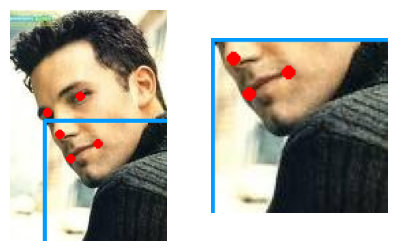

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(5,3))
axes[0].imshow(image)
axes[0].axis('off')
axes[1].imshow(face)
axes[1].axis('off')
plt.show()

## 2.3 입력형식에 맞게 차원 변환

In [72]:
face.shape

(89, 90, 3)

In [71]:
face_data = np.expand_dims(face, axis=0)
# face_data = face.reshape(-1, face.shape[0], face.shape[1],3)
face_data = face[np.newaxis, :]
face_data.shape

(1, 89, 90, 3)

# 3. FaceNet 활용하여 임베딩 데이터로 변환(face data를)
- face_data : 1x88x3x66x3
- 임베딩 데이터 : 1x512

In [73]:
# ! pip install keras-facenet

In [75]:
from keras_facenet import FaceNet
model = FaceNet()

## 3-1 이미지 데이터를 FaceNet 임베딩 데이터로 변환

In [78]:
# face_data 얼굴 이미지이거나 얼굴 특징 데이터가 있는 이미지를 유사성을 측정할 수 있는 1x512 배열
face_embedding = model.embeddings(face_data)
face_embedding.shape

1/1 [==============================] - 0s 79ms/step


(1, 512)

In [80]:
face_embedding[0, :10]

array([-0.0286289 , -0.00451101, -0.03675631,  0.06095084,  0.00348998,
        0.02183726, -0.06231577, -0.02000727, -0.00366194, -0.00119385],
      dtype=float32)

# 4. 분류모델을 만들기 위해서 데이터셋 생성
- X_train(nx512), y_train(n) * n은 train 폴더안의 사진 갯수
- X_test(mx512), y_test(m) * m은 test 폴더안의 사진 갯수

## 4.1 y_train(사람이름)과 X_train에 사용될 이미지 경로(x_train_path)
- y_test(사람이름)과 X_test에 사용될 이미지 경로(x_test_path)

In [81]:
import os
train_path = 'data/5celebrity/train'
test_path = 'data/5celebrity/val'

In [84]:
for x in os.walk(train_path):
    print(x)
    print('-----------------------------------------------------------')

('data/5celebrity/train', ['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling'], [])
-----------------------------------------------------------
('data/5celebrity/train\\ben_afflek', [], ['httpcsvkmeuaeccjpg.jpg', 'httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg', 'httpssmediacacheakpinimgcomxdbbdbbbececacdecdcdfjpg.jpg', 'httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg', 'httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg', 'httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg', 'httpssmediacacheakpinimgcomxeeedcacddeccccacfjpg.jpg', 'httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAffleckbyGageSkidmorejpg.jpg', 'httptrwebimgacstanetcxbdddmediasnmediajpg.jpg', 'httpwwwaceshowbizcomimagesphotobenaffleckjpg.jpg', 'httpwwwallposterscomimagesPostersPFjpg.jpg', 'httpwwwfilmscoopitcgibinattoriBENAFFLECKBENAFFLECKjpg.jpg', 'httpwwwhillsindcomstorebenjpg.jpg', 'httpwwwrumenewscomw

In [106]:
def get_path(path):
    x_path = []
    y = []
    for x in os.walk(path):
        if len(x[2])==0:
            continue
        name = os.path.basename(x[0])
        print(name, '사진', len(x[2]), '장 parsing 중')
        for file_name in x[2]:
            # image_full_path = x[0].replace('\\','/') + '/' + file_name
            image_full_path = path + '/' + name + '/' + file_name
            x_path.append(image_full_path)
            y.append(name)
#     print(len(y))
#     print(len(x_path))
#     for name, path in zip(y, x_path):
#         print(name,path)
    return x_path, y

In [107]:
# get_path(train_path)
x_train_path, y_train = get_path(train_path)
x_test_path, y_test = get_path(test_path)

ben_afflek 사진 14 장 parsing 중
elton_john 사진 16 장 parsing 중
jerry_seinfeld 사진 21 장 parsing 중
madonna 사진 19 장 parsing 중
mindy_kaling 사진 22 장 parsing 중
ben_afflek 사진 5 장 parsing 중
elton_john 사진 5 장 parsing 중
jerry_seinfeld 사진 5 장 parsing 중
madonna 사진 5 장 parsing 중
mindy_kaling 사진 5 장 parsing 중
